In [1]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from pandas import TimeGrouper
from pandas import DataFrame
from matplotlib import pyplot

import warnings
import scipy
import numpy
import matplotlib
import pandas
import sklearn
import statsmodels
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings("ignore")

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
series = Series.from_csv('data/champagne.csv', header=0)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('data/dataset.csv')
validation.to_csv('data/validation.csv')

Dataset 94, Validation 12


Test Strategy

Candidate models will be evaluated using walk-forward validation.

This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

The first 50% of the dataset will be held back to train the model.
The remaining 50% of the dataset will be iterated and test the model.
For each step in the test dataset:
* A model will be trained.
* A one-step prediction made and the prediction stored for later evaluation.
* The actual observation from the test dataset will be added to the training dataset for the next iteration.
* The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

Persistence

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance.

This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence.

This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [3]:
# load data
series = Series.from_csv('data/dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=8314.000, Expected=10651
>Predicted=10651.000, Expected=3633
>Predicted=3633.000, Expected=4292
>Predicted=4292.000, Expected=4154
>Predicted=4154.000, Expected=4121
>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2899.000, Expected=3370
>Predicted=3

### Summary Statistics

In [4]:
series.describe()

count       94.000000
mean      4666.010638
std       2484.748262
min       1573.000000
25%       3049.000000
50%       4031.500000
75%       5170.250000
max      13916.000000
dtype: float64

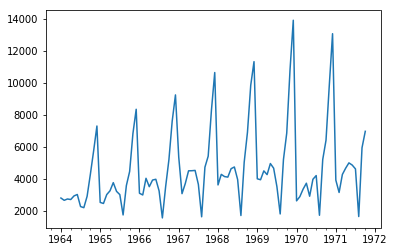

In [5]:
series.plot()

* There may be an increasing trend of sales over time.
* There appears to be systematic seasonality to the sales for each year.
* The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
* There do not appear to be any obvious outliers.
* The seasonality suggests that the series is almost certainly non-stationary.

In [6]:
TimeGrouper('A')

TimeGrouper(freq=<YearEnd: month=12>, axis=0, sort=True, closed='right', label='right', how='mean', convention='e', base=0)

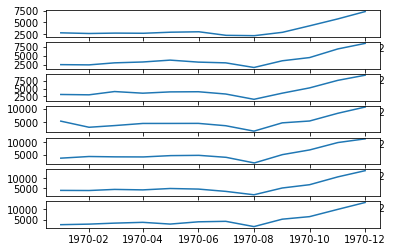

In [7]:

series = Series.from_csv('data/dataset.csv')
groups = series['1964':'1970'].groupby(TimeGrouper('A'))
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    pyplot.subplot((n_groups*100) + 10 + i)
    i += 1
    pyplot.plot(group)

We can clearly see a dip each August and a rise from each August to December. This pattern appears the same each year, although at different levels.

This will help with any explicitly season-based modeling later.

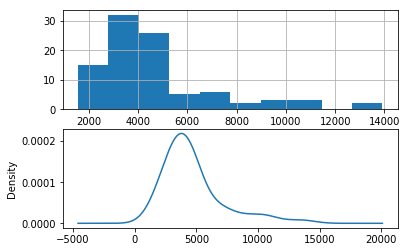

In [8]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')

* The distribution is not Gaussian.
* The shape has a long right tail and may suggest an exponential distribution

The example below groups the observations by year and creates one box and whisker plot for each year of observations. The last year (1971) only contains 9 months and may not be a useful comparison with the 12 months of observations for other years. Therefore, only data between 1964 and 1970 was plotted.

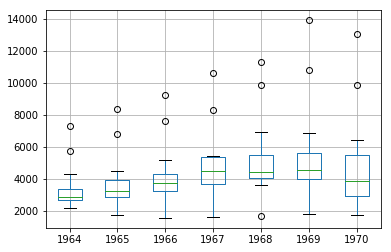

In [9]:
series = Series.from_csv('data/dataset.csv')
groups = series['1964':'1970'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()

* The median values for each year (green line) may show an increasing trend.
* The spread or middle 50% of the data (blue boxes) does appear reasonably stable.
* There are outliers each year (black circles); these may be the tops or bottoms of the seasonal cycle.
* The last year, 1970, does look different from the trend in prior years

### Predictions

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

ADF Statistic: -7.180580
p-value: 0.000000
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586


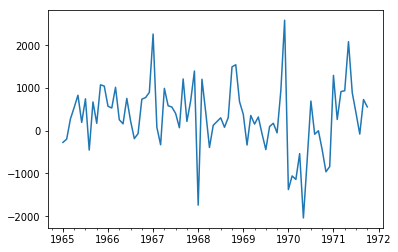

In [10]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
series = Series.from_csv('data/dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('data/stationary.csv')
# plot
stationary.plot()

The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [11]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

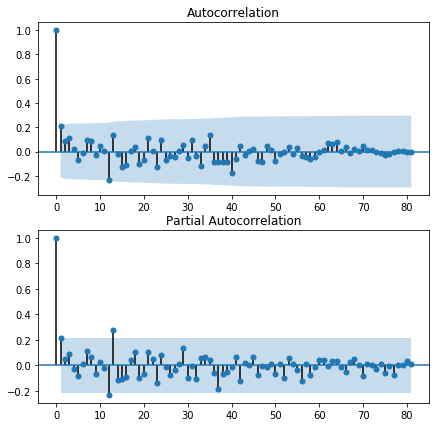

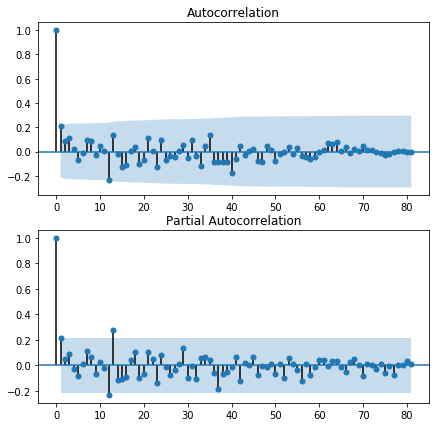

In [12]:
series = Series.from_csv('data/stationary.csv')
pyplot.figure(figsize=(7,7))
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())

* The ACF shows a significant lag for 1 month.
* The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
* Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

We may consider a better model of seasonality, such as modeling it directly and explicitly removing it from the model rather than seasonal differencing.

In [13]:
# load data
series = Series.from_csv('data/dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=9742.712, Expected=10651
>Predicted=5986.917, Expected=3633
>Predicted=3887.036, Expected=4292
>Predicted=4038.135, Expected=4154
>Predicted=4992.350, Expected=4121
>Predicted=5156.432, Expected=4647
>Predicted=5046.666, Expected=4753
>Predicted=4143.850, Expected=3965
>Predicted=2102.958, Expected=1723
>Predicted=5228.220, Expected=5048
>Predicted=5873.372, Expected=6922
>Predicted=8571.192, Expected=9858
>Predicted=11006.017, Expected=11331
>Predicted=4087.481, Expected=4016
>Predicted=4771.835, Expected=3957
>Predicted=4676.103, Expected=4510
>Predicted=4583.393, Expected=4276
>Predicted=5117.359, Expected=4968
>Predicted=5208.157, Expected=4677
>Predicted=4436.463, Expected=3523
>Predicted=2180.943, Expected=1821
>Predicted=5471.210, Expected=5222
>Predicted=7337.566, Expected=6872
>Predicted=10268.387, Expected=10803
>Predicted=11725.356, Expected=13916
>Predicted=4519.427, Expected=2639
>Predicted=4606.003, Expected=2899
>Predicted=4938.797, Expected=3370
>Predicted=44

Running this example results in an RMSE of 956.942, which is dramatically better than the persistence RMSE of 3186.501.

The ACF and PACF plots suggest that an ARIMA(1,0,1) or similar may be the best that we can do.

To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the test set. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

* p: 0 to 6.
* d: 0 to 2.
* q: 0 to 6.

This is (7 * 3 * 7), or 147, potential runs of the test harness and will take some time to execute.

It may be interesting to evaluate MA models with a lag of 12 or 13 as were noticed as potentially interesting from reviewing the ACF and PACF plots. Experimentation suggested that these models may not be stable, resulting in errors in the underlying mathematical libraries.

In [14]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('data/dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=933.954
ARIMA(0, 0, 2) RMSE=960.443
ARIMA(0, 0, 3) RMSE=943.894
ARIMA(0, 0, 4) RMSE=957.667
ARIMA(0, 0, 5) RMSE=987.147
ARIMA(0, 0, 6) RMSE=1088.173
ARIMA(0, 1, 1) RMSE=957.953
ARIMA(0, 2, 1) RMSE=1145.504
ARIMA(1, 0, 0) RMSE=941.572
ARIMA(1, 1, 0) RMSE=1070.469
ARIMA(1, 1, 1) RMSE=956.741
ARIMA(1, 2, 0) RMSE=1555.966
ARIMA(2, 0, 0) RMSE=955.363
ARIMA(2, 1, 0) RMSE=1029.710
ARIMA(2, 1, 1) RMSE=980.480
ARIMA(2, 2, 0) RMSE=1346.554
ARIMA(2, 2, 1) RMSE=1039.171
ARIMA(3, 0, 0) RMSE=957.986
ARIMA(3, 1, 0) RMSE=1027.364
ARIMA(3, 1, 1) RMSE=979.387
ARIMA(3, 2, 0) RMSE=1249.541
ARIMA(4, 0, 0) RMSE=967.274
ARIMA(4, 1, 0) RMSE=1045.708
ARIMA(4, 1, 1) RMSE=1005.796
ARIMA(4, 2, 0) RMSE=1229.438
ARIMA(4, 2, 1) RMSE=1055.001
ARIMA(5, 0, 0) RMSE=987.287
ARIMA(5, 1, 0) RMSE=1042.012
ARIMA(5, 1, 1) RMSE=1024.012
ARIMA(5, 1, 2) RMSE=1002.310
ARIMA(5, 2, 1) RMSE=1053.391
ARIMA(6, 0, 0) RMSE=996.320
ARIMA(6, 1, 0) RMSE=1017.993
ARIMA(6, 1, 1) RMSE=1024.029
ARIMA(6, 1, 2) RMSE=1033.411


### Review residual errors

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(0, 0, 1) model.

In [18]:
model_fit.resid

array([ -274.        ,  -129.14829485,   310.07081389,   462.84912634,
         707.3349415 ,     6.53695267,   744.26752673,  -650.2515015 ,
         845.33465301,   -51.03709001,  1087.52624205,   756.77543269,
         371.43355553,   432.55982294,   901.35966951,    18.11472929,
         156.19909515,   714.6029147 ,    42.61044054,  -197.29294661,
         -14.71190619,   740.89906251,   579.64123324,   743.37902316,
        2064.983975  ,  -465.27793195,  -205.68846467,  1045.51313857,
         305.91006844,   471.92536134,   277.92671182,    -3.65827431,
        1211.96954399,  -104.20548811,   727.61733976,  1204.16125753,
       -2061.13607599,  1750.25813217,   -27.86686897,  -385.6145081 ,
         229.19852216,   153.25604521,   261.38290442,    10.72629274,
         306.15723542,  1412.85985524,  1169.55301684,   370.03606608,
         284.93019634,  -410.51439163,   464.79768076,    31.81574454,
         312.56794673,  -158.83916076,  -399.9032242 ,   203.98542757,
      

                 0
count    47.000000
mean    156.790587
std     930.652816
min   -2164.247449
25%    -289.651596
50%     191.759548
75%     584.888982
max    2367.304752


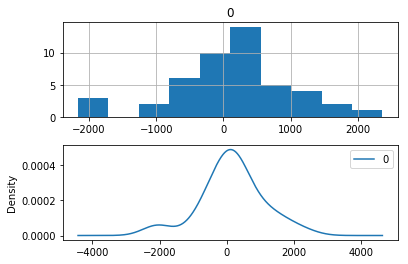

In [25]:
# load data
series = Series.from_csv('data/dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())

We can see that the distribution has a right shift and that the mean is non-zero at 156.790587.

This is perhaps a sign that the predictions are biased.

The graphs suggest a Gaussian-like distribution with a bumpy left tail, providing further evidence that perhaps a power transform might be worth exploring.

### We could use this information to bias-correct predictions by adding the mean residual error of 165.904728 to each forecast made.

The example below performs this bias correlation.

RMSE: 920.699
                 0
count    47.000000
mean      0.000001
std     930.652815
min   -2321.038036
25%    -446.442183
50%      34.968961
75%     428.098395
max    2210.514165


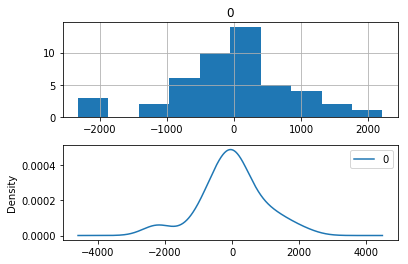

In [26]:
# load data
series = Series.from_csv('data/dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 156.790587
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())

The performance of the predictions is improved very slightly from 939.464 to 924.699, which may or may not be significant.

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

The example below re-calculates the residual errors and creates ACF and PACF plots to check for any significant autocorrelation.

                 0
count    47.000000
mean      0.000002
std     930.652817
min   -2321.038036
25%    -446.442183
50%      34.968961
75%     428.098395
max    2210.514165


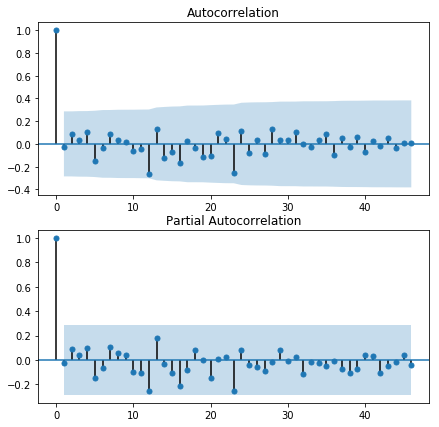

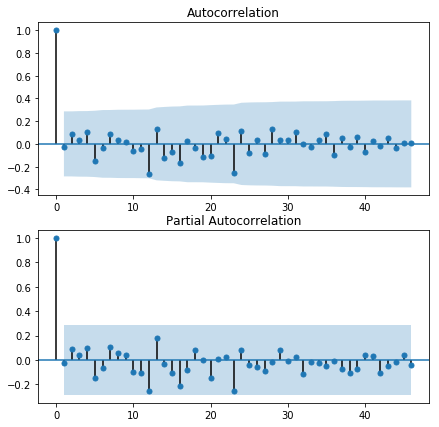

In [28]:
# load data
series = Series.from_csv('data/dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 156.790587
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure(figsize=(7, 7))
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())

### Model Validation

In [47]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

# load data
series = Series.from_csv('data/dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 156
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
* model_bias.npy This is the bias value stored as a one-row, one-column NumPy array.

In [48]:
from statsmodels.tsa.arima_model import ARIMAResults

series = Series.from_csv('data/dataset.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 10091.859


>Predicted=10091.859, Expected=9851
>Predicted=13209.163, Expected=12670
>Predicted=3986.631, Expected=4348
>Predicted=3456.029, Expected=3564
>Predicted=4512.779, Expected=4577
>Predicted=4891.432, Expected=4788
>Predicted=5180.189, Expected=4618
>Predicted=4920.286, Expected=5312
>Predicted=4934.880, Expected=4298
>Predicted=1689.504, Expected=1413
>Predicted=6075.419, Expected=5877
RMSE: 368.870


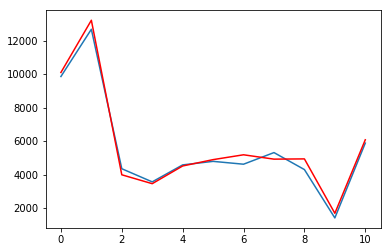

In [49]:
# load and prepare datasets
dataset = Series.from_csv('data/dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('data/validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')

The final RMSE for the validation period is predicted at 368.870 million sales.

This is much better than the expectation of an error of a little more than 924 million sales per month.